In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import sys 
installation_path = "/content/drive/MyDrive/Colab_Installations_V2"
# The path is being modified so that everything installed in the installation path can now be used without re-installing (in this case, I just need biopython)
sys.path.insert(0,installation_path)
protein_mpnn_path = "/content/drive/MyDrive/Protein_MPNN_Digging/ProteinMPNN/vanilla_proteinmpnn"
sys.path.insert(0,protein_mpnn_path)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Protein_MPNN_Digging

/content/drive/MyDrive/Protein_MPNN_Digging


In [ ]:
import re
import matplotlib.pyplot as plt
import shutil
import warnings
import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split, Subset
import copy
import torch.nn as nn
import torch.nn.functional as F
import random
import os
from protein_mpnn_utils import loss_nll, loss_smoothed, gather_edges, gather_nodes, gather_nodes_t, cat_neighbors_nodes, _scores, _S_to_seq, tied_featurize, parse_PDB
from protein_mpnn_utils import StructureDataset, StructureDatasetPDB, ProteinMPNN
from Bio.PDB import *

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

In [ ]:
import pandas as pd
from tqdm.notebook import tqdm
from Bio.PDB.Polypeptide import *

In [ ]:
weights_path = os.path.join(protein_mpnn_path,"vanilla_model_weights")
model_name = "v_48_020"
checkpoint_path = os.path.join(weights_path,model_name+".pt")

In [ ]:
# Now, load and dig into the checkpoint object
checkpoint = torch.load(checkpoint_path, map_location=device) 

In [ ]:
hidden_dim = 128
num_layers = 3 
# Seems like, backbone_noise is set to 0 at inference path which seems logical
backbone_noise=0.00
mpnn_model = ProteinMPNN(num_letters=21, node_features=hidden_dim, edge_features=hidden_dim, hidden_dim=hidden_dim, num_encoder_layers=num_layers, num_decoder_layers=num_layers, augment_eps=backbone_noise, k_neighbors=checkpoint['num_edges'])
mpnn_model.to(device)
mpnn_model.load_state_dict(checkpoint['model_state_dict'])
mpnn_model.eval()

In [ ]:
print(checkpoint['model_state_dict'].keys())

odict_keys(['features.embeddings.linear.weight', 'features.embeddings.linear.bias', 'features.edge_embedding.weight', 'features.norm_edges.weight', 'features.norm_edges.bias', 'W_e.weight', 'W_e.bias', 'W_s.weight', 'encoder_layers.0.norm1.weight', 'encoder_layers.0.norm1.bias', 'encoder_layers.0.norm2.weight', 'encoder_layers.0.norm2.bias', 'encoder_layers.0.norm3.weight', 'encoder_layers.0.norm3.bias', 'encoder_layers.0.W1.weight', 'encoder_layers.0.W1.bias', 'encoder_layers.0.W2.weight', 'encoder_layers.0.W2.bias', 'encoder_layers.0.W3.weight', 'encoder_layers.0.W3.bias', 'encoder_layers.0.W11.weight', 'encoder_layers.0.W11.bias', 'encoder_layers.0.W12.weight', 'encoder_layers.0.W12.bias', 'encoder_layers.0.W13.weight', 'encoder_layers.0.W13.bias', 'encoder_layers.0.dense.W_in.weight', 'encoder_layers.0.dense.W_in.bias', 'encoder_layers.0.dense.W_out.weight', 'encoder_layers.0.dense.W_out.bias', 'encoder_layers.1.norm1.weight', 'encoder_layers.1.norm1.bias', 'encoder_layers.1.norm2.

In [ ]:
# Parse and create dictionaries for all the mutations in PremPS 2648
# This dictionary will be a dictionary of dictionaries, where outer-dict keys will be pdbid+mutchain and inner-dict keys will be (wild+pos+mut) and ddg
# the icodes can be brought to picture later
git_url = "https://raw.githubusercontent.com/SajidAhmeduiu/PremPS/main/Datasets/S2648/S2648.txt"
dataset =  pd.read_csv(git_url,delimiter="\t")

pdbIds = list(dataset["PDB Id"])
mutChains = list(dataset["Mutated Chain"])
mutations = list(dataset["Mutation_PDB"])
ddgs = list(dataset["DDGexp"])

two_level_dict = {}

for pdbId, mutChain, mutation, ddg in tqdm(zip(pdbIds,mutChains,mutations,ddgs)):
    pos = [int(s) for s in re.findall('-?\d+',mutation)][0]
    wild = mutation[0]
    mut = mutation[len(mutation)-1]

    pdbId = pdbId.lower()

    inner_dict = {}
    inner_dict["mut"] = f"{wild}{pos}{mut}"
    inner_dict["ddg"] = float(ddg)
    outer_key = f"{pdbId}{mutChain}"
    if outer_key not in two_level_dict:
        two_level_dict[f"{pdbId}{mutChain}"] = [inner_dict]
    else:
        two_level_dict[f"{pdbId}{mutChain}"].append(inner_dict)

0it [00:00, ?it/s]

In [ ]:
# create a seqres to position mapping dictionary
# This dictionary will be a dictionary of dictionaries, where outer-dict keys will be pdbid+mutchain and inner-dict key will be (wild+pos) and value of 0-indexed position
# the icodes can be brought to picture later
mapping_dict = {}
pdbDirectory = "/content/drive/MyDrive/ACCRE_PyRun_Setup/S_2648_PDB_Files"
parser = PDBParser(QUIET=True)
# some proteins need to be skipped for now due to ICODE related discrapency
proteins_to_skip = []

for filename in tqdm(os.listdir(pdbDirectory)):
    filepath = os.path.join(pdbDirectory,filename)
    structure = parser.get_structure(id=filename.split(".")[0],file=filepath)
    model = structure[0]
    inner_dict = {}
    outer_key = filename.split(".")[0]
    skip_flag = False
    # single chain-assumption in action again
    for chain in model:
        for i,residue in enumerate(chain):
            inner_key = f"{three_to_one(residue.get_resname())}{residue.get_id()[1]}"
            if inner_key not in inner_dict:
                inner_dict[inner_key] = i
            else:
                # For "2immA:N31" and "1lveA:S27", I have been fucked
                # Need to think whether this will effect other positions or I can just avoid these two-protein related mutations for now?
                # Let me just avoid these two proteins for now
                print("YOU HAVE JUST BEEN FUCKED BY ICODE")
                print(f"{outer_key}:{inner_key}")
                skip_flag = True
    # The ICODE related problematic proteins will not be considered for now
    if not skip_flag:
        mapping_dict[outer_key] = inner_dict
    else:
        proteins_to_skip.append(outer_key)

  0%|          | 0/131 [00:00<?, ?it/s]

YOU HAVE JUST BEEN FUCKED BY ICODE
1lveA:S27
YOU HAVE JUST BEEN FUCKED BY ICODE
1lveA:S27
YOU HAVE JUST BEEN FUCKED BY ICODE
2immA:N31
YOU HAVE JUST BEEN FUCKED BY ICODE
2immA:N31


In [ ]:
# read in the PDB files from the directory where the S_2648 PDB Files are stored, and set-them up one by one for featuirization, and passing through the model
pdbDirectory = "/content/drive/MyDrive/ACCRE_PyRun_Setup/S_2648_PDB_Files"
parser = PDBParser(QUIET=True)
entered = 0
wtf_chains = []
for i,filename in enumerate(os.listdir(pdbDirectory)):
    #ICODE related problematic proteins will be skipped from analysis for now
    if filename.split(".")[0] not in proteins_to_skip:
        filepath = os.path.join(pdbDirectory,filename)
        structure = parser.get_structure(id=filename.split(".")[0],file=filepath)
        model = structure[0]
        
        # Since there is only one chain, and that same chain is both fixed designable for different residues, extracting that name, and putting them in pertinent lists
        chain_name = list(model.child_dict.keys())[0]
        fixed_chain_list = []
        # the trick is to put the single chain as designable chain, and then create the "fixed_positions_dict" dictionary  
        designed_chain_list = [chain_name]
        chain_list = list(set(designed_chain_list + fixed_chain_list))

        # Using the programs custome PDB parser for processing the PDB files
        pdb_dict_list = parse_PDB(filepath, input_chain_list=chain_list)
        # tacking max_length parameter value from the original colab notebook since I need to process all residues at the same time
        # all the PDB files can technically be processed together and put inside the dataset_valid list-like object, but right now
        # I am trying to keep everything consistent
        # Each element of dataset_valid is a dictionary 
        dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=20000)

        # At this point, probably need to put None values in a lot of parameters that are not relevant to my usecase, but need to be sent to featurizer before running model forward
        # For now, I will not tie positions together
        tied_positions_dict = None
        pssm_dict = None
        omit_AA_dict = None
        bias_AA_dict = None
        tied_positions_dict = None
        bias_by_res_dict = None
        alphabet = 'ACDEFGHIKLMNPQRSTVWYX'
        bias_AAs_np = np.zeros(len(alphabet))
        
        # I do not even think temperature is necessary for my usecase since I am not trying to generate sequences,
        # still keeping a value for code consistency
        temperatures = [0.1]

        # This "chain_id_dict" seems like a parameter that definitely has some effect on  
        chain_id_dict = {}
        chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

        BATCH_COPIES = 1   
        
        # print(chain_id_dict)
        # Simplying the sequence generation loop
        protein = dataset_valid[0]
        wildtype_seq = protein[f"seq_chain_{designed_chain_list[0]}"]
        # print(wildtype_seq)
        # only need to mask the mutated position position in "wildtype_seq" for now

        # "muts_for_prot" is a list with information about all the mutations in "protein", whose sequence only version is "wildtype_seq" 
        muts_for_prot = two_level_dict[filename.split(".")[0]]
        # "cur_map_dict" will give the 0-based sequence index for the mutations, which will be almost directly used for masking and then running the model
        # Now, for the last time need to make sure whether the fixed positions need to be 0-indexed or 1-indexed
        cur_map_dict = mapping_dict[filename.split(".")[0]]
        check = False
        for mut in muts_for_prot:
            wild_aa = mut["mut"][0]
            seq_pos = cur_map_dict[mut["mut"][0:-1]]
            # print(f"{wild_aa},{wildtype_seq[seq_pos]}")
            if wild_aa!=wildtype_seq[seq_pos]:
                if not check:
                    wtf_chains.append(filename.split(".")[0])
                    check = True
                # print("WTF is going on?")
                # entered = entered + 1
        
# print(entered)

In [ ]:
# read in the PDB files from the directory where the S_2648 PDB Files are stored, and set-them up one by one for featuirization, and passing through the model
pdbDirectory = "/content/drive/MyDrive/ACCRE_PyRun_Setup/S_2648_PDB_Files"
parser = PDBParser(QUIET=True)
for i,filename in tqdm(enumerate(os.listdir(pdbDirectory))):
    #ICODE related problematic proteins will be skipped from analysis for now
    if filename.split(".")[0] not in proteins_to_skip:
        if i > 70:
            break
        filepath = os.path.join(pdbDirectory,filename)
        structure = parser.get_structure(id=filename.split(".")[0],file=filepath)
        model = structure[0]
        
        # Since there is only one chain, and that same chain is both fixed designable for different residues, extracting that name, and putting them in pertinent lists
        chain_name = list(model.child_dict.keys())[0]
        fixed_chain_list = []
        # the trick is to put the single chain as designable chain, and then create the "fixed_positions_dict" dictionary  
        designed_chain_list = [chain_name]
        chain_list = list(set(designed_chain_list + fixed_chain_list))

        # Using the programs custome PDB parser for processing the PDB files
        pdb_dict_list = parse_PDB(filepath, input_chain_list=chain_list)
        # tacking max_length parameter value from the original colab notebook since I need to process all residues at the same time
        # all the PDB files can technically be processed together and put inside the dataset_valid list-like object, but right now
        # I am trying to keep everything consistent
        # Each element of dataset_valid is a dictionary 
        dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=20000)

        # Simplying the sequence generation loop
        protein = dataset_valid[0]
        wildtype_seq = protein[f"seq_chain_{designed_chain_list[0]}"]

        # If there are gaps in the wildtype_seq "seq", remove those positions from both the "seq", "" and ('coords_chain_{designed_chain_list[0]}'), 
        # and ('seq_chain_{designed_chain_list[0]}') of the "protein"
        # print(protein.keys())
        # protein is a dict with keys(['seq_chain_A', 'coords_chain_A', 'name', 'num_of_chains', 'seq'])
        # "seq_chain" and "seq_all" are both strings of the same length where gapped positions need to be identified and removed
        seq_chain = protein[f"seq_chain_{designed_chain_list[0]}"]
        seq_all = protein[f"seq"]
        # "coordinates_chain" is a dict with keys(['N_chain_A', 'CA_chain_A', 'C_chain_A', 'O_chain_A'])
        coordinates_chain = protein[f"coords_chain_{designed_chain_list[0]}"]
        
        # The following four variables are lists of length equal to seq_chain and seq_all length
        # Therefore, the gapped positions can be retrived from seq_chain and removed from everything accordingly
        N_chain = coordinates_chain[f"N_chain_{designed_chain_list[0]}"]
        CA_chain = coordinates_chain[f"CA_chain_{designed_chain_list[0]}"]
        C_chain = coordinates_chain[f"C_chain_{designed_chain_list[0]}"]
        O_chain = coordinates_chain[f"O_chain_{designed_chain_list[0]}"]

        # delete everything related to gapped positions now
        # at first, find out the positions that are gapped
        N_chain = [v for i,v in enumerate(N_chain) if seq_chain[i] != "-"]
        CA_chain = [v for i,v in enumerate(CA_chain) if seq_chain[i] != "-"]
        C_chain = [v for i,v in enumerate(C_chain) if seq_chain[i] != "-"]
        O_chain = [v for i,v in enumerate(O_chain) if seq_chain[i] != "-"]
        seq_all = [v for i,v in enumerate(seq_all) if seq_chain[i] != "-"]
        seq_chain = [v for i,v in enumerate(seq_chain) if seq_chain[i] != "-"]

        # Now, finally, pack everything back to the dictionary "protein"
        protein[f"seq_chain_{designed_chain_list[0]}"] = seq_chain
        protein[f"seq"] = seq_all
        coordinates_chain[f"N_chain_{designed_chain_list[0]}"] = N_chain
        coordinates_chain[f"CA_chain_{designed_chain_list[0]}"] = CA_chain
        coordinates_chain[f"C_chain_{designed_chain_list[0]}"] = C_chain
        coordinates_chain[f"O_chain_{designed_chain_list[0]}"] = O_chain
        protein[f"coords_chain_{designed_chain_list[0]}"] = coordinates_chain

        # At this point, probably need to put None values in a lot of parameters that are not relevant to my usecase, but need to be sent to featurizer before running model forward
        # For now, I will not tie positions together
        tied_positions_dict = None
        pssm_dict = None
        omit_AA_dict = None
        bias_AA_dict = None
        tied_positions_dict = None
        bias_by_res_dict = None
        alphabet = 'ACDEFGHIKLMNPQRSTVWYX'
        bias_AAs_np = np.zeros(len(alphabet))

        chain_id_dict = {}
        chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

        BATCH_COPIES = 1

        batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]

        # "muts_for_prot" is a list with information about all the mutations in "protein", whose sequence only version is "wildtype_seq" 
        muts_for_prot = two_level_dict[filename.split(".")[0]]
        # "cur_map_dict" will give the 0-based sequence index for the mutations, which will be almost directly used for masking and then running the model
        # 1-based indexing needed for the fixed position
        cur_map_dict = mapping_dict[filename.split(".")[0]]

        for mut in muts_for_prot:
            wild_aa = mut["mut"][0]
            # (+1) because we need to pass 1-based indexing to tied_featurize() method
            seq_pos = cur_map_dict[mut["mut"][0:-1]] + 1
            # only need to mask the mutated position position in "wildtype_seq" for now
            fixed_positions_dict = {}
            fixed_positions_dict[protein["name"]] = {}
            fixed_positions_dict[protein["name"]][filename.split(".")[0][-1]] = [seq_pos]
            X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, \
            omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta  \
            = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict)
            randn_1 = torch.randn(chain_M.shape, device=X.device)
            log_probs = mpnn_model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
            # Adding the log_probs to the same inner dictionary where DDG values exist for easier comparison
            mut["log_prob"] = log_probs.cpu().data.numpy()

0it [00:00, ?it/s]

In [ ]:
# Save the incomplete "two_level_dict" as pickle file for a quick dirty comparison
# import pickle
# with open("res_dict.pickle","wb") as f:
#     pickle.dump(two_level_dict,f)

In [ ]:
# import pickle
# with open("res_dict.pickle","rb") as f:
#     two_level_dict = pickle.load(f)

In [ ]:
proteins_to_skip

['1lveA', '2immA']

In [ ]:
print(len(mapping_dict),len(two_level_dict))

129 132


In [ ]:
from scipy.stats import entropy
alpha_list = list("ACDEFGHIKLMNPQRSTVWYX")
# The following dictionary will be used for fetching out the log-probabilities corresponding to the wild-type and mutated residues at the mutation positions
aa_to_N = {a:n for n,a in enumerate(alpha_list)}
# This list will contain the experimental ddg values for the mutations for which two-level dict contains information regarding log_probabilities
true_vals = []
# This list will contain (wild_proba,mut_proba) tuples for the mutations for which two-level dict contains information regarding log_probabilities
wild_mut_log_probabilities = []
# saving max probabilites for debugging
max_log_probabilities = []
# Want to add entropy of the position with some kind of weight (maybe, just a for loop for checking weight combinations that sum to 1?)
position_entropies = []
for prot,muts in two_level_dict.items():
    if prot not in proteins_to_skip:
        try:
            cur_map_dict = mapping_dict[prot]
        except:
            continue
        for mut in muts:
            # only fetching those mutations that have corresponding log-probabilities calculated and saved as values of "log_prob" key
            if "log_prob" in mut:
                wild = mut["mut"][0] 
                alternate = mut["mut"][-1]
                true_vals.append(mut["ddg"])
                sequence_index_of_mutation = cur_map_dict[mut["mut"][0:-1]]
                position_log_probabilities = mut["log_prob"][0,sequence_index_of_mutation,:]
                wild_mut_log_probabilities.append((position_log_probabilities[aa_to_N[wild]],position_log_probabilities[aa_to_N[alternate]]))
                max_log_probabilities.append(position_log_probabilities.max())
                position_entropies.append(entropy(np.exp(position_log_probabilities)))
    # Take only those mutations where "log_prob" is available and make a quick comparison for correlation plot
    # Next, read in PSSM, and do same
    # Then tree-way plot
    # Then linear regression with PSSM + log_prob for the specific positions
    # Then log-prob to probability distribution, and entropy calculation

In [ ]:
# let us also look at the energy of the most probable amino acid in those mutation positions
wild_energies = []
mut_energies = []
min_energies = []
experimental_energies = []
entropy_conservations = []
# Now, add entropy of the position
for true, estimate, max_prob, entropy_conservation in zip(true_vals,wild_mut_log_probabilities,max_log_probabilities,position_entropies):
    experimental_energies.append(true)
    wild_energies.append(estimate[0]*-1)
    mut_energies.append(estimate[1]*-1)
    min_energies.append(max_prob*-1)
    entropy_conservations.append(entropy_conservation*-1)

In [ ]:
from scipy.stats import pearsonr

In [ ]:
wild_energies = np.array(wild_energies)
mut_energies = np.array(mut_energies)
min_energies = np.array(min_energies)
experimental_energies = np.array(experimental_energies)
mut_wild_predictions = mut_energies - wild_energies
mut_min_predictions = mut_energies - min_energies
entropy_predictions = np.array(entropy_conservations)
print(pearsonr(experimental_energies,mut_wild_predictions))
print(pearsonr(experimental_energies,mut_min_predictions))
print(pearsonr(experimental_energies,entropy_predictions))

(0.5039796931516946, 1.1540078589851597e-118)
(0.47514244445972786, 7.216792853340412e-104)
(0.36357299179696995, 2.1792875788131823e-58)


In [ ]:
# Now combine "mut_wild_predictions" and "entropy_predictions" using weight combinations from 0 to 1 in 0.05 increments so that they some to one
# so, when one weight is x, the other weight is automatically (1-x)
# The keys of this dictionary will be (term1_coeff,term2_coeff) tuples, and values will be the observed correlations 
coefficient_result_dictionary = {}
for i in np.arange(0.0,1.000001,0.005):
    term1_coeff = round(i,2)
    term2_coeff = round((1.000001 - i),2)
    local_preds = (term1_coeff*mut_wild_predictions) + (term2_coeff*entropy_predictions)
    coefficient_result_dictionary[(term1_coeff,term2_coeff)] = round(pearsonr(experimental_energies,local_preds)[0],2) 

In [ ]:
coefficient_result_dictionary

{(0.0, 1.0): 0.36,
 (0.01, 0.99): 0.37,
 (0.02, 0.98): 0.38,
 (0.02, 0.99): 0.38,
 (0.03, 0.97): 0.39,
 (0.04, 0.96): 0.4,
 (0.04, 0.97): 0.4,
 (0.05, 0.95): 0.41,
 (0.06, 0.94): 0.41,
 (0.06, 0.95): 0.41,
 (0.07, 0.93): 0.42,
 (0.08, 0.92): 0.43,
 (0.08, 0.93): 0.42,
 (0.09, 0.91): 0.43,
 (0.1, 0.9): 0.44,
 (0.1, 0.91): 0.44,
 (0.11, 0.89): 0.44,
 (0.12, 0.88): 0.45,
 (0.12, 0.89): 0.45,
 (0.13, 0.87): 0.45,
 (0.14, 0.86): 0.46,
 (0.14, 0.87): 0.46,
 (0.15, 0.85): 0.46,
 (0.16, 0.84): 0.46,
 (0.16, 0.85): 0.46,
 (0.17, 0.83): 0.47,
 (0.18, 0.82): 0.47,
 (0.18, 0.83): 0.47,
 (0.19, 0.81): 0.47,
 (0.2, 0.8): 0.48,
 (0.2, 0.81): 0.48,
 (0.21, 0.79): 0.48,
 (0.22, 0.78): 0.48,
 (0.22, 0.79): 0.48,
 (0.23, 0.77): 0.48,
 (0.24, 0.76): 0.49,
 (0.24, 0.77): 0.49,
 (0.25, 0.75): 0.49,
 (0.26, 0.74): 0.49,
 (0.26, 0.75): 0.49,
 (0.27, 0.73): 0.49,
 (0.28, 0.72): 0.49,
 (0.28, 0.73): 0.49,
 (0.29, 0.71): 0.5,
 (0.29, 0.72): 0.5,
 (0.3, 0.7): 0.5,
 (0.3, 0.71): 0.5,
 (0.31, 0.69): 0.5,
 (0.32, 0.

In [ ]:
# let me get PSSM values and do some comparison quickly
# getting the PSSM extraction functions from my custom model data processing scripts
from string import ascii_uppercase

# In rare cases, some PDB files number chains with 1,2,3 instead of A,B,C
def convertChainFromAlphabetToNumber(alphabet):
    mappingDict = {ch:(idx+1) for idx,ch in enumerate(ascii_uppercase)}
    return str(mappingDict[alphabet])

# Before executing this function, the PSSM files with naming format "pdbIdchain.pssm" needs to be stored
# in the pssm_dir
def returnPSSMArray(pdbIdPlusChain,pssm_dir="train_pssm_dir",convert_upper = False):
#     Currently, assuming that the pssm file names contain pdbId in upper case
    if convert_upper:
        fileName = pdbIdPlusChain.upper() + ".pssm"
    else:
        fileName = pdbIdPlusChain + ".pssm"
    try:
        fullPath = os.path.join(pssm_dir,fileName)
        f = open(fullPath)
    except:
        fileName = pdbIdPlusChain[0:4].upper() + str(convertChainFromAlphabetToNumber(pdbIdPlusChain[4])) + ".pssm" 
        fullPath = os.path.join(pssm_dir,fileName)
        f = open(fullPath)
        
# #     all the target lines in the PSSM files have (2+20+20+2=44) strings after line.split()
    target_lines = [line.split() for line in f.readlines() if (len(line.split()))==44]
    number_of_residues = len(target_lines)
    
    pssm_features = np.zeros((number_of_residues,20))

    for idx,line in enumerate(target_lines):
        pssm_features[idx,:] = line[2:22]

    f.close()
    
    return pssm_features

# This function also seems necessary for extracting the two pssm values
# Must review the three pssm feature functions (this one and the two above) later
# These functions seem to be taking up a lot of time....must review
def returnPSSMMapping(residue):
    pssm_letter_to_index_dict = {"A" : 0,   
    "R" : 1,
    "N" : 2,
    "D" : 3,
    "C" : 4,
    "Q" : 5,
    "E" : 6,
    "G" : 7,
    "H" : 8,
    "I" : 9,
    "L" : 10,
    "K" : 11,
    "M" : 12,
    "F" : 13,
    "P" : 14,
    "S" : 15,
    "T" : 16,
    "W" : 17,
    "Y" : 18,
    "V" : 19}

    return pssm_letter_to_index_dict[residue]


# I will add PSSM values to the two-level dictionary for places where log_prob is available
pssmDirectory = "/content/drive/MyDrive/ACCRE_PyRun_Setup/S_2648_pssm_dir"
for prot,muts in two_level_dict.items():
    if prot not in proteins_to_skip:
        try:
            cur_map_dict = mapping_dict[prot]
        except:
            continue
        for mut in muts:
            # only fetching those mutations that have corresponding log-probabilities calculated and saved as values of "log_prob" key
            if "log_prob" in mut:
                wild = mut["mut"][0] 
                alternate = mut["mut"][-1]
                sequence_index_of_mutation = cur_map_dict[mut["mut"][0:-1]]
                pdbId = prot[0:-1]
                mutChain = prot[-1]
                pssm_array = returnPSSMArray(pdbId + mutChain,pssm_dir=pssmDirectory,convert_upper = False)
                position_pssm = pssm_array[sequence_index_of_mutation]
                wild_pssm = position_pssm[returnPSSMMapping(wild)] 
                alternate_pssm = position_pssm[returnPSSMMapping(alternate)]
                mut["wild_pssm"] = wild_pssm
                mut["alternate_pssm"] = alternate_pssm

In [ ]:
pssm_predictions = []
for prot,muts in two_level_dict.items():
    if prot not in proteins_to_skip:
        try:
            cur_map_dict = mapping_dict[prot]
        except:
            continue
        for mut in muts:
            # only fetching those mutations that have corresponding log-probabilities calculated and saved as values of "log_prob" key
            if "log_prob" in mut:
                pssm_predictions.append((mut["wild_pssm"]-mut["alternate_pssm"]))

In [ ]:
wild_energies = np.array(wild_energies)
mut_energies = np.array(mut_energies)
min_energies = np.array(min_energies)
experimental_energies = np.array(experimental_energies)
mut_wild_predictions = mut_energies - wild_energies
mut_min_predictions = mut_energies - min_energies
entropy_predictions = np.array(entropy_conservations)
pssm_predictions = np.array(pssm_predictions)
print(pearsonr(experimental_energies,mut_wild_predictions))
print(pearsonr(experimental_energies,entropy_predictions))
print(pearsonr(experimental_energies,pssm_predictions))

(0.5039796931516946, 1.1540078589851597e-118)
(0.36357299179696995, 2.1792875788131823e-58)
(0.27925546194094136, 3.467385570005848e-34)


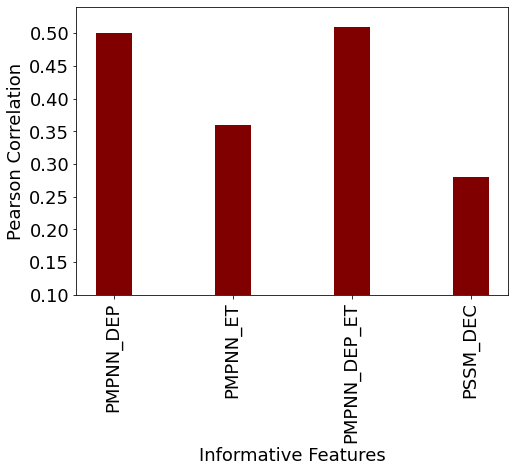

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])
# versions = [1,4,5,7,Run_21]
methods = ['PMPNN_DEP','PMPNN_ET','PMPNN_DEP_ET','PSSM_DEC']
vals = [0.50,0.36,0.51,0.28]
plt.ylabel("Pearson Correlation",fontsize=18)
plt.xlabel("Informative Features",fontsize=18)
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)
plt.ylim(0.10,0.54)
ax.bar(methods,vals,color="maroon",width=0.3)
plt.show()

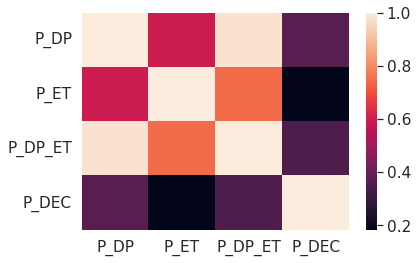

In [ ]:
import pandas as pd
import seaborn as sns

mut_wild_predictions = np.array(mut_energies - wild_energies)
entropy_predictions = np.array(entropy_conservations)
first_second_combined = 0.5*mut_wild_predictions + 0.5*entropy_predictions
pssm_predictions = np.array(pssm_predictions)

df_Ssym = pd.DataFrame(
    {'P_DP': mut_wild_predictions,
     'P_ET': entropy_predictions,
     'P_DP_ET':first_second_combined,
     'P_DEC': pssm_predictions
    })
corr = df_Ssym.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

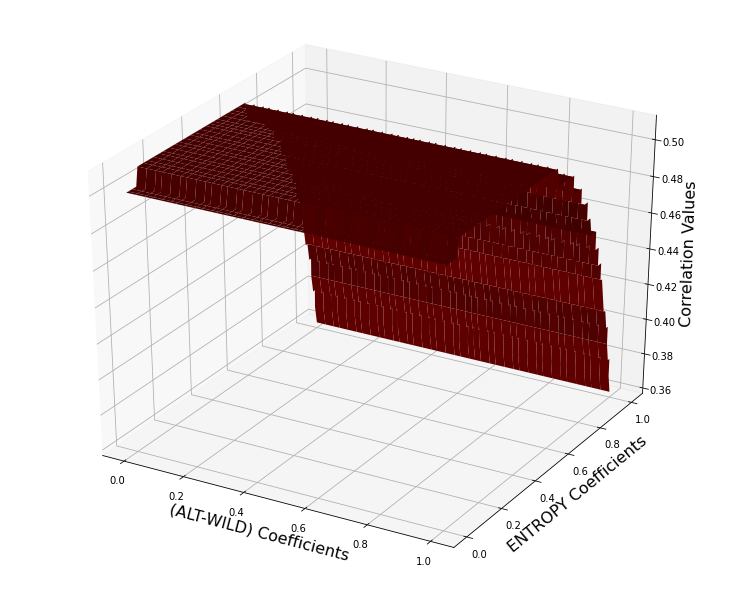

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
x = np.array([i for (i,j) in coefficient_result_dictionary.keys()])
y = np.array([j for (i,j) in coefficient_result_dictionary.keys()])
X_g, Y_g = np.meshgrid(x, y)
correlations_vals = np.array([i for i in coefficient_result_dictionary.values()]).reshape(-1,1)
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)
ax.plot_surface(X_g, Y_g, correlations_vals,label="Linear Combination Correlations",color="maroon")
# ax.legend()
ax.set_xlabel("(ALT-WILD) Coefficients",fontsize=16)
ax.set_ylabel("ENTROPY Coefficients",fontsize=16)
# set z ticks and labels
# ax.set_zticks([-2, 0, 2])
# change fontsize
# for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
# disable auto rotation
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('Correlation Values', fontsize=16, rotation = 88)
# plt.zlabel("ENTROPY Coefficients",fontsize=16)
plt.show()

In [ ]:
print(X_g.shape)

(154, 154)


In [ ]:
print(correlations_vals.shape)

(154,)


In [ ]:
# import time

# def parse_PDB_biounits_local(x, atoms=['N', 'CA', 'C'], chain=None):
#     '''
#     input:  x = PDB filename
#             atoms = atoms to extract (optional)
#     output: (length, atoms, coords=(x,y,z)), sequence
#     '''

#     alpha_1 = list("ARNDCQEGHILKMFPSTWYV-")
#     states = len(alpha_1)
#     alpha_3 = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE',
#                'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL', 'GAP']

#     # The following dictionaries are mapping from one-letter to 0-20 index,
#     # three-letter to 0-20 index,
#     # 0-20 index to one-letter,
#     # one-letter to three-letter, and vice-versa
#     aa_1_N = {a: n for n, a in enumerate(alpha_1)}
#     aa_3_N = {a: n for n, a in enumerate(alpha_3)}
#     aa_N_1 = {n: a for n, a in enumerate(alpha_1)}
#     aa_1_3 = {a: b for a, b in zip(alpha_1, alpha_3)}
#     aa_3_1 = {b: a for a, b in zip(alpha_1, alpha_3)}

#     def AA_to_N(x):
#         # ["ARND"] -> [[0,1,2,3]]
#         x = np.array(x);
#         if x.ndim == 0: x = x[None]
#         return [[aa_1_N.get(a, states - 1) for a in y] for y in x]

#     def N_to_AA(x):
#         # [[0,1,2,3]] -> ["ARND"]
#         x = np.array(x);
#         if x.ndim == 1: x = x[None]
#         return ["".join([aa_N_1.get(a, "-") for a in y]) for y in x]

#     xyz, seq, min_resn, max_resn = {}, {}, 1e6, -1e6
#     for line in open(x, "rb"):
#         line = line.decode("utf-8", "ignore").rstrip()

#         if line[:6] == "HETATM" and line[17:17 + 3] == "MSE":
#             line = line.replace("HETATM", "ATOM  ")
#             line = line.replace("MSE", "MET")

#         if line[:4] == "ATOM":
#             ch = line[21:22]
#             # This is definitely where things are going wrong
#             # since {'': 'LEU'} this cannot be the correct format; where the fuck is the residue number?
#             if ch == chain or chain is None:
#                 atom = line[12:12 + 4].strip()
#                 resi = line[17:17 + 3]
#                 resn = line[22:22 + 5].strip()
#                 x, y, z = [float(line[i:(i + 8)]) for i in [30, 38, 46]]

#                 if resn[-1].isalpha():
#                     resa, resn = resn[-1], int(resn[:-1]) - 1
#                 else:
#                     resa, resn = "", int(resn) - 1
#                 #         resn = int(resn)
#                 if resn < min_resn:
#                     min_resn = resn
#                 if resn > max_resn:
#                     max_resn = resn
#                 if resn not in xyz:
#                     xyz[resn] = {}
#                 if resa not in xyz[resn]:
#                     xyz[resn][resa] = {}
#                 if resn not in seq:
#                     seq[resn] = {}
#                 if resa not in seq[resn]:
#                     seq[resn][resa] = resi

#                 if atom not in xyz[resn][resa]:
#                     xyz[resn][resa][atom] = np.array([x, y, z])

#     # convert to numpy arrays, fill in missing values
#     seq_, xyz_ = [], []
#     try:
#         for resn in range(min_resn, max_resn + 1):
#             if resn in seq:
#                 # "seq_" is the [0,20] tokenized version of the sequence
#                 # 20 for any non-natural type
#                 for k in sorted(seq[resn]): seq_.append(aa_3_N.get(seq[resn][k], 20))
#             else:
#                 seq_.append(20)
#             if resn in xyz:
#                 for k in sorted(xyz[resn]):
#                     for atom in atoms:
#                         if atom in xyz[resn][k]:
#                             xyz_.append(xyz[resn][k][atom])
#                         else:
#                             xyz_.append(np.full(3, np.nan))
#             else:
#                 for atom in atoms: xyz_.append(np.full(3, np.nan))
#         print(f"Printed from inside mpnn parser:{seq_}")
#         for i,v in enumerate(seq_):
#             if v > 19:
#                 print(f"This is where the shit is happening from")
#                 # print(f"{(N_to_AA(np.array(seq_)))[i]}")
#                 # Why the fuck will a list and its numpy array versions not have the same length?
#                 # print(f"{len(seq_)},{len(N_to_AA(np.array(seq_))[0])}")
#                 # why is 126 giving a key error?
#                 print(seq[i],(N_to_AA(np.array(seq_)))[0][i],seq_[i])
#         # "N_to_AA(np.array(seq_)" is the single letter [all 20, -] version of the sequence
#         return np.array(xyz_).reshape(-1, len(atoms), 3), N_to_AA(np.array(seq_))
#     except TypeError:
#         return 'no_chain', 'no_chain'


# ### calling signature
# # pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
# def parse_PDB_local(path_to_pdb, input_chain_list=None):
#     c = 0
#     pdb_dict_list = []
#     init_alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
#                      'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
#                      'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
#     extra_alphabet = [str(item) for item in list(np.arange(300))]
#     chain_alphabet = init_alphabet + extra_alphabet

#     if input_chain_list:
#         chain_alphabet = input_chain_list

#     biounit_names = [path_to_pdb]
#     # Each of the biounits is a separate PDB file, so for running with a single PDB file like from colab, this loop will be executed only once
#     for biounit in biounit_names:
#         my_dict = {}
#         s = 0
#         concat_seq = ''
#         concat_N = []
#         concat_CA = []
#         concat_C = []
#         concat_O = []
#         concat_mask = []
#         coords_dict = {}
#         # This loop will be executed only once for single chain DDG type cases
#         for letter in chain_alphabet:
#             xyz, seq = parse_PDB_biounits_local(biounit, atoms=['N', 'CA', 'C', 'O'], chain=letter)
#             if type(xyz) != str:
#                 concat_seq += seq[0]
#                 my_dict['seq_chain_' + letter] = seq[0]
#                 coords_dict_chain = {}
#                 coords_dict_chain['N_chain_' + letter] = xyz[:, 0, :].tolist()
#                 coords_dict_chain['CA_chain_' + letter] = xyz[:, 1, :].tolist()
#                 coords_dict_chain['C_chain_' + letter] = xyz[:, 2, :].tolist()
#                 coords_dict_chain['O_chain_' + letter] = xyz[:, 3, :].tolist()
#                 my_dict['coords_chain_' + letter] = coords_dict_chain
#                 s += 1
#         fi = biounit.rfind("/")
#         my_dict['name'] = biounit[(fi + 1):-4]
#         my_dict['num_of_chains'] = s
#         my_dict['seq'] = concat_seq
#         if s <= len(chain_alphabet):
#             pdb_dict_list.append(my_dict)
#             c += 1
#     return pdb_dict_list

# class StructureDatasetPDB_local():
#     def __init__(self, pdb_dict_list, verbose=True, truncate=None, max_length=100,
#         alphabet='ACDEFGHIKLMNPQRSTVWYX-'):
#         alphabet_set = set([a for a in alphabet])
#         discard_count = {
#             'bad_chars': 0,
#             'too_long': 0,
#             'bad_seq_length': 0
#         }

#         self.data = []

#         start = time.time()
#         # elements of pdb_dict_list are dictionaries containing information regarding a specific pdb file
#         for i, entry in enumerate(pdb_dict_list):
#             seq = entry['seq']
#             name = entry['name']

#             bad_chars = set([s for s in seq]).difference(alphabet_set)
#             if len(bad_chars) == 0:
#                 if len(entry['seq']) <= max_length:
#                     self.data.append(entry)
#                 else:
#                     discard_count['too_long'] += 1
#             else:
#                 discard_count['bad_chars'] += 1

#             # Truncate early
#             if truncate is not None and len(self.data) == truncate:
#                 return

#             if verbose and (i + 1) % 1000 == 0:
#                 elapsed = time.time() - start

#             #print('Discarded', discard_count)
#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx]

In [ ]:
# # For these wtf_chains, compare the sequences recovered by my parsing function and MPNN parsing function\
# pdbDirectory = "/content/drive/MyDrive/ACCRE_PyRun_Setup/S_2648_PDB_Files"
# parser = PDBParser(QUIET=True)
# for chain in wtf_chains:
#     my_seq = "".join([key[0] for key, val in mapping_dict[chain].items()])
    
#     filename = f"{chain}.pdb"
#     filepath = os.path.join(pdbDirectory,filename)
#     structure = parser.get_structure(id=filename.split(".")[0],file=filepath)
#     model = structure[0] 
#     # Since there is only one chain, and that same chain is both fixed designable for different residues, extracting that name, and putting them in pertinent lists
#     chain_name = list(model.child_dict.keys())[0]
#     fixed_chain_list = []
#     # the trick is to put the single chain as designable chain, and then create the "fixed_positions_dict" dictionary  
#     designed_chain_list = [chain_name]
#     chain_list = list(set(designed_chain_list + fixed_chain_list))
#     # Using the programs custome PDB parser for processing the PDB files
#     dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=20000)
#     protein = dataset_valid[0]
#     wildtype_seq = protein[f"seq_chain_{designed_chain_list[0]}"]
#     mpnn_seq = wildtype_seq
#     print(f"chain:{chain}")
#     print(f"my_seq:{my_seq}")
#     print(f"mpnn_seq:{mpnn_seq}")
#     # Let me see if the sequences can be perfectly aligned by removing gaps from the mpnn_seq
#     gap_removed_mpnn_seq = "".join(ele for ele in mpnn_seq if ele!="-")
#     print(f"gap_removed_mpnn_seq:{gap_removed_mpnn_seq}")
#     for i,j in zip(my_seq,gap_removed_mpnn_seq):
#         if i!=j:
#             print("Still problems,DAMN")
#             break
#     print("................................")
#     print("................................")
#     # WTF are these gaps doing here in these protein mpnn parsed sequences?????
#     # need to check the PDB parsing codeblock 
#     # Seems like gaps have been inserted at "RANDOM" places due to some weird reason
#     # one solution could be to take the gapless sequence and map it somehow, which should be fairly simple
#     # but why are there gaps in the first place?
#     # what is the utility of these gaps?
#     # These gaps are inserted in the "parse_PDB_biounits()" function of the utils.py file
#     # But, why?
#     # seems like something is getting mapped to "GAP/-/20" through the function  N_to_AA(x), maybe through AA_to_N(x), but why? which entry does not have a corresponding value in the dictionaries?

In [ ]:
# Now, have to trace the function protein_mpnn_utils.tied_featurize
# after tracing and understanding this function in a workable way, I can run through model forward, get probabilities, play around, find simple correlation
# submit batch jobs, and then move onto other ideas listed in my workbook, add those slides to the presentation to be shown to Jens in a week
# seems like full-chain design vs. specific position design is the issue here
# Where is the key to going from full-chain-design to specific-position-design?
# Dig into the "mask" and "chain_M" variables of the forward method of "ProteinMPNN" for figuring out how to control "designable" vs. "fixed" residues
# How to populate the "fixed_positions_dict" dictionary? putting the only chain as designable and populating this dictionary 
# seems like "fixed_pos_list"  can be an 1-indexed integer list corresponding to positions in "chain_seq"
# I think, "fixed_position_mask" and "chain_mask" interact with each other at some point
# very possibly, there could be an element-wise product going on at some point during decoding, which prevents fixed_positions in designable chains from being masked out